## 同时计算不同长度之间的关联
achen@2021-7-11

In [7]:
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import text as mtext
import numpy as np
import math
from matplotlib.transforms import Affine2D, Bbox
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch,Rectangle,Circle,Polygon
from matplotlib.path import Path

from collections import Counter
from scipy import stats


In [8]:
from format_utils import process_data

In [9]:
color_map = {'A': '#009980',
        'C': '#59B3E6',
        'G': '#E69B04',
        'T': '#1A1A1A',
        'N': 'grey'}

In [10]:
seqs = []
with open('./test.fa','r') as inpf:
    for line in inpf:
        line = line.strip()
        if line[0] == '>':
            continue
        seqs.append(line)
seqs[:10]

['GTCGGCCCCGCACCTGCGGAGGCACCCC',
 'GTCTTCCCCATGTGCGTGGGGGTGTTTC',
 'GTTGAACCGTACCTATGAGAGAT',
 'CCTATGCCGACCCTTCTTTGGGGGTTGGCCGACAAC',
 'GTTCGCTGCCGCATAGGCAGCTAAGAAA',
 'CCGCCAAACCTCTGATGCCGCAAGGCTTTGAGCAC',
 'TGTTTTAGTGGATCTTGATCGCGAAT',
 'GGACTTCCCCCGCCCACGGGGATGATCCC',
 'CGACCCACCTCCGCTGGCGCGGAGAGCAC',
 'GTTTTAGTTTCTTTGAGTTGTTAC']

In [11]:
bigTable = {}
for seq_len in sorted(set([len(seq) for seq in seqs])):
    #print('seq_len: ',seq_len)
    curr_seqs = [seq for seq in seqs if len(seq) == seq_len]
    #print(curr_seqs)
    summary = {}
    for pos in range(seq_len):
        summary[pos] = {}
        for seq in curr_seqs:
            summary[pos][seq[pos]] = summary[pos].get(seq[pos],0) + 1
    bigTable[seq_len] = summary


In [12]:
ic_table = {}
seq_lens = sorted(set([len(seq) for seq in seqs]))
for seq_len in seq_lens:
    if seq_len > 27:
        continue
    with open('tmp/tmp.fa','w') as outpf:
        i = 0
        for seq in seqs:
            if len(seq) != seq_len:
                continue
            i += 1
            outpf.write(f'>seq{i}\n')
            outpf.write(seq + '\n')
    pfm,ic = process_data('./tmp/tmp.fa',data_type='fasta')
    ic_table[seq_len] = ic.copy()

/data1/chenyaowen/workspace/varylen_seqlogo/vllogo/format_utils.py:106: RuntimeWarning: divide by zero encountered in log2
  -pfm[b][l] * np.nan_to_num(np.log2(pfm[b][l])) for b in bases
/data1/chenyaowen/workspace/varylen_seqlogo/vllogo/format_utils.py:111: RuntimeWarning: divide by zero encountered in log2
  [pfm[b][l] * np.nan_to_num(np.log2(pfm[b][l])) for b in bases])


In [13]:
padded = {}
related_table = {}
for seq_len in ic_table:
    #print(seq_len)
    v1 = ic_table[seq_len]
    if seq_len + 1 not in ic_table:
        continue
    v2 = ic_table[seq_len + 1]
    arr1 = []
    for i in range(seq_len):
        idict = dict(v1[i])
        item = [idict[x] for x in 'ATGC']
        arr1 += item
    corrs = {}
    for lack_i in range(seq_len + 1):
        arr2 = []
        for i in range(seq_len + 1):
            if i == lack_i :
                continue
            idict = dict(v2[i])
            item = [idict[x] for x in 'ATGC']
            arr2 += item
        corrs[lack_i] = list(stats.pearsonr(arr1,arr2))
    max_lacki = sorted(corrs.items(),key=lambda d:d[1][0],reverse=True)[0][0]
    longer_index = list(range(seq_len+1))
    padded[seq_len+1] = max_lacki 
    del longer_index[max_lacki]
    related_table[f'{seq_len}-{seq_len+1}'] = {}

    for li,si in zip(longer_index,list(range(seq_len))):
        corr = stats.pearsonr([dict(v1[si])[x] for x in 'ATGC'],[dict(v2[li])[x] for x in 'ATGC'])
        if corr[1] < 0.05:
            related_table[f'{seq_len}-{seq_len+1}'][f'{si}-{li}'] = corr[0]
        else:
            related_table[f'{seq_len}-{seq_len+1}'][f'{si}-{li}'] = 0
        #print(corr)
    


seq_len:  23
len of ic:  23
[0, 0]
seq_len:  24
len of ic:  24
[0, 0.3358868666480691]
in padded:  1
(1.01, 0.3358868666480691) 1.0000000000000002 0.42467574110731604
max_ceiling:  0.7605626077553852
seq_len:  25
len of ic:  25
[0, 0.8605626077553852]
in padded:  7
(7.069999999999999, 0.8605626077553852) 0.9999999999999991 0.32161295534670925
max_ceiling:  1.2304397857629543
seq_len:  26
len of ic:  26
[0, 1.3304397857629544]
in padded:  19
(19.190000000000005, 1.3304397857629544) 1.0 0.08019231642405919
max_ceiling:  1.9451622476411257
seq_len:  27
len of ic:  27
[0, 2.0451622476411258]
in padded:  9
(9.09, 2.0451622476411258) 1.0 0.297591950164314
max_ceiling:  2.893926754487202
[8.08, 0.09416852614204947] [9.08, 0.09416852614204947] [9.09, 0.3358868666480691] [10.09, 0.3358868666480691]
[21.210000000000008, 0.1206712663566218] [22.210000000000008, 0.1206712663566218] [22.22000000000001, 0.3358868666480691] [23.22000000000001, 0.3358868666480691]
[1.01, 0.7605626077553852] [2.0100000

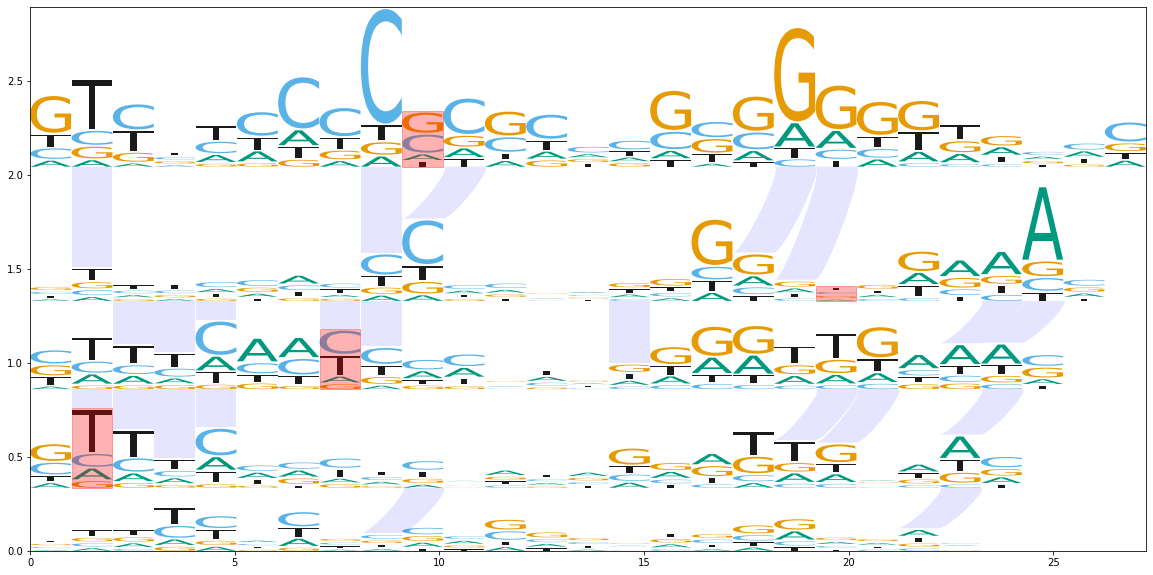

In [17]:
fig, ax = plt.subplots(1, 1,figsize=(20,10))

width = 1
panel_vpad = 0.1
base_hpad = 0.01
base_vpad = 0.01

max_path = TextPath((0, 0), 'E', size=1)
maxbox = max_path.get_extents()
start_point = None
patch_dict ={}

for seq_len in sorted(list(ic_table.keys())):
    
    ic = ic_table[seq_len]
    print('seq_len: ',seq_len)
    print('len of ic: ',len(ic))
    if not start_point:
        start_point = [0,0]
    else:
        start_point = [start_point[0],max_ceiling+panel_vpad]
    print(start_point)

    patch_dict[seq_len] = {}

    base_start = start_point.copy()
    max_ceiling = -1
    j = -1
    for pos_arr in ic:
        j += 1
        if j > 0:
            base_start[0] += width + base_hpad
        patch_dict[seq_len][j] = []
        i = -1
        floor = base_start[1] 
        st = sorted(pos_arr,key=lambda d:d[1])
        for base,bit in st:
            i += 1
            base_height = bit
            if bit < 0.001:
                continue
            base_cor = [base_start[0],floor]
            #print(base,base_cor)
            tmp_path = TextPath((0,0), base, size=1)
            bbox = tmp_path.get_extents()
            hoffset = (width - bbox.width * width / max(bbox.width,maxbox.width))/2
            transformation = Affine2D() \
                .translate(tx=-bbox.xmin, ty=-bbox.ymin) \
                .scale(sx=width/max(bbox.width,maxbox.width), sy=base_height/bbox.height) \
                .translate(tx=base_cor[0] + hoffset,ty=base_cor[1])
            final_path = transformation.transform_path(tmp_path)
            #print(final_path.get_extents())
            patch = PathPatch(final_path,
                              facecolor=color_map[base],                              
                              alpha=1,
                              edgecolor=color_map[base],
                              linewidth=0)
            #print(patch.get_extents())
            #print('windows',patch.get_window_extent())

            ax.add_patch(patch)
            tmpbox = final_path.get_extents()
            #box = Rectangle((tmpbox.x0,tmpbox.y0),tmpbox.width,tmpbox.height)
            #ax.add_patch(box)
            #print(patch.get_extents())
            #assert(1==2)
            patch_dict[seq_len][j].append(tmpbox)
            #print(base,base_height)
            floor += base_height + base_vpad
            if floor > max_ceiling:
                max_ceiling = floor
        
    lacked_i = padded.get(seq_len,-1)
    if lacked_i == -1:
        continue
    print('in padded: ',lacked_i)
    b0 = patch_dict[seq_len][lacked_i][0]
    hsum = sum([x.height for x in patch_dict[seq_len][lacked_i]]) + len(patch_dict[seq_len][lacked_i])*base_vpad
    print((b0.x0,b0.y0),b0.width,hsum)
    box = Rectangle((b0.x0,b0.y0),b0.width,hsum,alpha=0.3,color='r')
    ax.add_patch(box)

    print('max_ceiling: ',max_ceiling)    
filled_box = {}
for seq_len in sorted(list(ic_table.keys())):
    if seq_len+1 not in ic_table:
        continue
    rt = related_table[f'{seq_len}-{seq_len+1}']#[f'{si}-{li}'] = corr[0]
    for key in rt:
        si,li = key.split('-')
        if rt[key]>=0.95:
            #draw box
            bs = patch_dict[seq_len][int(si)]
            hsum = sum([x.height for x in bs]) + len(bs)*base_vpad
            box = Rectangle((bs[0].x0,bs[0].y0),bs[0].width,hsum,alpha=0.1,color='blue')

            #if f'{seq_len}-{si}' not in filled_box:
                
            #ax.add_patch(box)

            filled_box[f'{seq_len}-{si}'] = 1
 
            bs2 = patch_dict[seq_len+1][int(li)]
            hsum = sum([x.height for x in bs2]) + len(bs2)*base_vpad
            box = Rectangle((bs2[0].x0,bs2[0].y0),bs2[0].width,hsum,alpha=0.1,color='blue')

            #if f'{seq_len}-{li}' not in filled_box:
            #ax.add_patch(box)
            filled_box[f'{seq_len}-{li}'] = 1
            
            #draw connect
            p0 = [bs[-1].x0,bs[-1].y0+bs[-1].height+base_vpad]
            p1 = [bs[-1].x0+bs[-1].width,bs[-1].y0 + bs[-1].height+base_vpad]
            p2 = [bs2[0].x0,bs2[0].y0]
            p3 = [bs2[0].x0+bs2[0].width,bs2[0].y0]
            print(p0,p1,p2,p3)
            #assert(1==2)
            if si > li:
                direction = 'left'
            #ax.add_patch(Polygon(xy=[p0,p1,p3,p2], fill='blue',alpha=0.1,color='blue',linewidth=0))
            ax.add_patch(curve_connect(p0,p2,p3,p1,limit_width=width/4,direction='right',fill=True,alpha=0.1,color='blue',linewidth=0))



ax.set_xlim(0,len(ic) + len(ic)*base_hpad )
ax.set_ylim(0, max_ceiling )
plt.show()

In [16]:
def curve_connect(leftbot,lefttop,righttop,rightbot,limit_width,direction='right',**kargs):
    if np.abs((leftbot[0] - lefttop[0])/limit_width)< 0.1:
        return Polygon(xy=[leftbot,lefttop,righttop,rightbot], **kargs)
    else:
        #verts = [leftbot,rightbot,righttop,lefttop,righttop,]
        if direction == 'left':
            limit_width = -limit_width
        p0 = leftbot
        p1 = (leftbot[0] + limit_width, leftbot[1])
        p2 = (lefttop[0] + limit_width, lefttop[1])
        p3 = lefttop
        p4 = righttop
        p5 = (righttop[0] + limit_width,righttop[1])
        p6 = (rightbot[0] + limit_width, rightbot[1])
        p7 = rightbot
        p8 = p0

        verts = [p0,p1,p2,p3,p4,p5,p6,p7,p8]

        codes = [
            Path.MOVETO,
            Path.CURVE4,
            Path.CURVE4,
            Path.CURVE4,
            Path.LINETO,
            Path.CURVE4,
            Path.CURVE4,
            Path.CURVE4,
            Path.CLOSEPOLY
        ]
        path = Path(verts, codes)
        patch = patches.PathPatch(path, **kargs)
        return patch


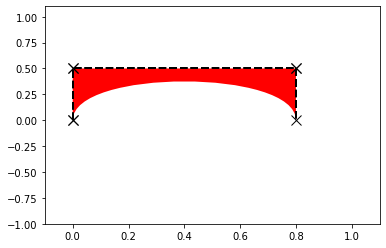

In [63]:
verts = [
   (0., 0.),   # P0
   (0, 0.5),  # P1
   (0.8, 0.5),  # P2
   (0.8, 0.),  # P3
   (0.8,0.5),
   (0,0.5),
   (0,0)
]

codes = [
    Path.MOVETO,
    Path.CURVE4,
    Path.CURVE4,
    Path.CURVE4,
    Path.LINETO,
    Path.LINETO,
    Path.CLOSEPOLY
]

path = Path(verts, codes)

fig, ax = plt.subplots()
patch = patches.PathPatch(path, facecolor='red', lw=0,fill='True')
ax.add_patch(patch)

xs, ys = zip(*verts)
ax.plot(xs, ys, 'x--', lw=2, color='black', ms=10)

#ax.text(-0.05, -0.05, 'P0')
#ax.text(0.15, 1.05, 'P1')
#ax.text(1.05, 0.85, 'P2')
#ax.text(0.85, -0.05, 'P3')

ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-1, 1.1)
plt.show()


In [61]:
path

Path(array([[ 0. ,  0. ],
       [ 0. ,  0.5],
       [ 0.8,  0.5],
       [ 0.8,  0. ],
       [ 0.8, -0.5],
       [ 0. , -0.5],
       [ 0. ,  0. ]]), array([ 1,  4,  4,  4,  1,  1, 79], dtype=uint8))

In [43]:
dir(path)

['CLOSEPOLY',
 'CURVE3',
 'CURVE4',
 'LINETO',
 'MOVETO',
 'NUM_VERTICES_FOR_CODE',
 'STOP',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_codes',
 '_fast_from_codes_and_verts',
 '_interpolation_steps',
 '_readonly',
 '_should_simplify',
 '_simplify_threshold',
 '_unit_circle',
 '_unit_circle_righthalf',
 '_unit_rectangle',
 '_unit_regular_polygons',
 '_unit_regular_stars',
 '_update_values',
 '_vertices',
 'arc',
 'circle',
 'cleaned',
 'clip_to_bbox',
 'code_type',
 'codes',
 'contains_path',
 'contains_point',
 'contains_points',
 'copy',
 'deepcopy',
 'get_extents',
 'hatch',
 'interpolated',
 'intersects_bbox',
 'inter

In [55]:
#path.to_polygons()
#path.interpolated(10)
#for x in path.iter_bezier():
#    print(x)
path

Path(array([[0. , 0. ],
       [0. , 0.5],
       [0.8, 0.5],
       [0.8, 0. ],
       [0. , 0. ]]), array([ 1,  4,  4,  4, 79], dtype=uint8))

In [27]:
with tempfile.TemporaryDirectory() as td:
    f_name = os.path.join(td, 'test.fa')
    print(f_name)

/tmp/tmp9l0xjec7/test


In [33]:
'x' assert len({x for x in [1,2,3,3]}) == 3

SyntaxError: invalid syntax (<ipython-input-33-de215137e850>, line 1)

In [4]:
from scipy.stats import spearmanr,pearsonr

In [8]:
pearsonr([1,2,3,4,5,0,0,0,0],[2,3,4,5,6,0,0,0,0]),pearsonr([1,2,3,4,5],[2,3,4,5,6])

((0.9918365981341756, 1.6055885793694087e-07), (1.0, 0.0))

In [20]:
import numpy as np
np.array([1,2,3]).max()
np.argwhere(np.array([1,23,1])==1).squeeze()

array([0, 2])

In [1]:
1 + 1

2

In [4]:
a = 100

In [2]:
a

NameError: name 'a' is not defined

In [3]:
a = 1

In [7]:
b = 10

In [ ]:
b

Error: Kernel is dead

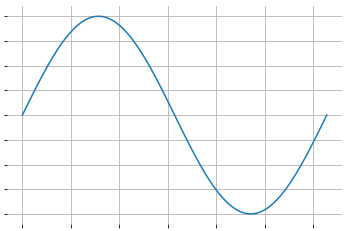

In [12]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

ax = plt.subplot(111)
ax.plot(x, y)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.grid()


# Only show ticks on the left and bottom spines
#ax.yaxis.set_ticks_position('left')
#ax.xaxis.set_ticks_position('bottom')

plt.show()
